In [1]:
import function_sleepWakeLabels as sleep
from save_gsvds import save_gsvds
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob
import re
from os.path import join
from pathlib import Path
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pickle

sns.set_theme(style="darkgrid")

In [5]:
dat_dir = '/Users/loranknol/HPC_project/data/'

all_files = sorted(glob.glob("sub-*/preproc/*dat-kp.csv", root_dir=dat_dir, recursive=True))

pat = re.compile(r"sub-(\d+)")
subs = [re.match(pat, f).group(1) for f in all_files]

gsvd_file = 'gsvd_results.pkl'

Calculate graph SVDs, save them to file, and read them back in.

In [ ]:
# Calculate graph SVDs and save to file
save_gsvds(dat_dir, all_files, subs, out_file=gsvd_file)

In [6]:
with open(join(dat_dir, gsvd_file), 'rb') as handle:
    gsvd_results = pickle.load(handle)

Extract (complete rows of) CLEAR-3 sleep data.

In [7]:
self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports_raw[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()
self_reports['daterated'] = self_reports['daterated'].map(lambda d: date.fromisoformat(d))
self_reports

/var/folders/p7/qsy7v2sd3_j1ypyqv03cpv7r0000gp/T/ipykernel_1730/4202685588.py:1: DtypeWarning: Columns (5,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,126,128,136,137,138,139,140,142,145,150,151,156,158) have mixed types. Specify dtype option on import or set low_memory=False.
  self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)


,id,daterated,sleepdur_yest,SleepLNQuality
1,3001,2020-11-14,2.0,2.0
2,3001,2020-11-15,4.0,2.0
3,3001,2020-11-16,4.0,2.0
4,3001,2020-11-17,5.0,3.0
5,3001,2020-11-18,7.0,3.0
...,...,...,...,...
32749,3118,2022-11-10,5.0,2.0
32750,3118,2022-11-11,4.0,2.0
32751,3118,2022-11-12,4.0,2.0
32753,3118,2022-11-14,5.0,2.0


Generate plots of predicted and true sleep for every subject.

In [ ]:
# I don't want all these plots embedded in this notebook
backend = mpl.rcParams['backend']
mpl.use("agg")

Path('images').mkdir(exist_ok=True)

cors = {}
sleep_scores = {}

for sub, res in gsvd_results.items():
    Mactivity = res['Mactivity']
    Mspeed = res['Mspeed']
    svd = res['svd']
    sleepMatrix = res['sleepMatrix']

    # Plot steps
    plot = sleep.plot_heatmaps(Mactivity, Mspeed, svd, sleepMatrix)
    plot.savefig("images/matrices_sub-{}.png".format(sub), dpi=300)
    plt.close()

    sr_sub = self_reports.loc[self_reports['id'] == int(sub)]

    # Fuse self-report with day numbers
    merged = res['dates'].merge(sr_sub, how='outer', left_on='date', right_on='daterated')
    sub_sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']]

    # Fuse self-report with predicted sleep scores
    days = Mactivity.index
    sleep_pred = np.sum(1 - sleepMatrix, axis=1)
    sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})
    sub_sleep_scores = sub_sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')
    sleep_scores[sub] = sub_sleep_scores
    
    ### Plot sleep duration
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep duration sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['sleepdur_yest'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/duration_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Plot sleep quality
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep quality sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['SleepLNQuality'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/quality_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Scatter plot
    ss_complete = sub_sleep_scores.dropna()

    if len(ss_complete.index) < 2:
        cor = 0.0
        p_cor = 1.0
    else:
        cor_res = pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred'])
        cor = cor_res.statistic
        p_cor = cor_res.pvalue

    cors[sub] = {
        'cor': cor,
        'p_cor': p_cor
    }

    sns.stripplot(sub_sleep_scores, x="sleepdur_yest", y="sleep_pred", alpha=0.4) \
        .set(
            title=fr"Sub {sub}, $\rho$ = {cor:.2f} (p = {p_cor:.2g})",
            xlabel="Reported sleep duration (hours)",
            ylabel="Predicted sleep duration (hours)"
        )

    plt.savefig("images/scatter_sub-{}.png".format(sub), dpi=300)

    plt.close()

mpl.use(backend)

Save sleep scores (id, day number, sleep duration, sleep quality, and predicted sleep duration) to file. To be used in R.

In [ ]:
sleep_scores_df = pd.concat(sleep_scores).reset_index(0, names="id")
sleep_scores_df.to_csv(join(dat_dir, "sleep_scores.csv"), index=False)

Analyse the relationships between high correlation values and subject data characteristics

In [7]:
zipped = list(zip(*cors.items()))
cor_subs = [int(id) for id in zipped[0]]
(cor_cors, cor_pvals) = list(zip(*[d.values() for d in zipped[1]]))

cor_df = pd.DataFrame({'id': cor_subs, 'correlation': cor_cors, 'pvalue': cor_pvals})

cor_reports = self_reports.merge(cor_df, how='outer', on='id')
cor_reports = cor_reports.loc[~np.isnan(cor_reports['correlation'])]
cor_reports = cor_reports.groupby('id').agg(
    n=pd.NamedAgg('sleepdur_yest', 'size'),
    correlation=pd.NamedAgg('correlation', 'first')
)

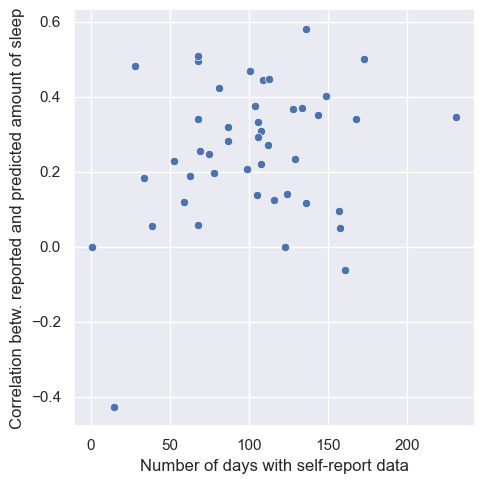

In [35]:
%matplotlib inline

sns.relplot(cor_reports, x='n', y='correlation') \
    .set(
        xlabel="Number of days with self-report data",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_self-report.png", dpi=300)

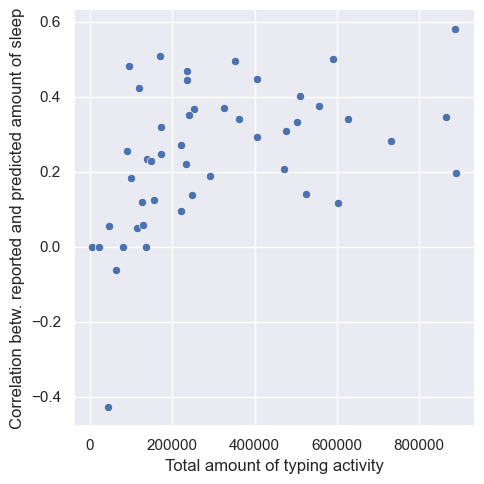

In [40]:
total_activities = [np.sum(np.array(res['Mactivity'])) for res in gsvd_results.values()]
cor_reports['activity'] = total_activities

sns.relplot(cor_reports, x='activity', y='correlation')\
    .set(
        xlabel="Total amount of typing activity",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity.png", dpi=300)

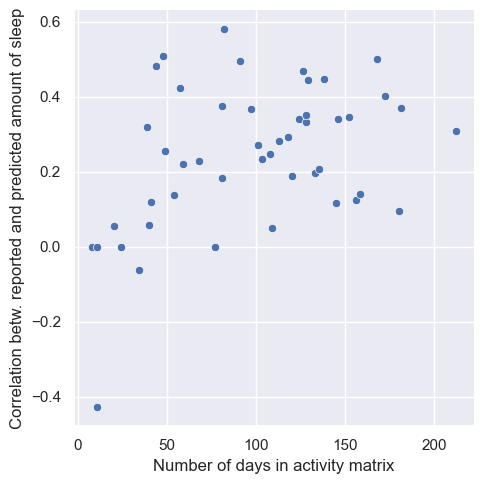

In [41]:
cor_reports['n_matrix'] = [len(res['Mactivity'].index) for res in gsvd_results.values()]

sns.relplot(cor_reports, x='n_matrix', y='correlation')\
    .set(
        xlabel="Number of days in activity matrix",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_mat.png", dpi=300)

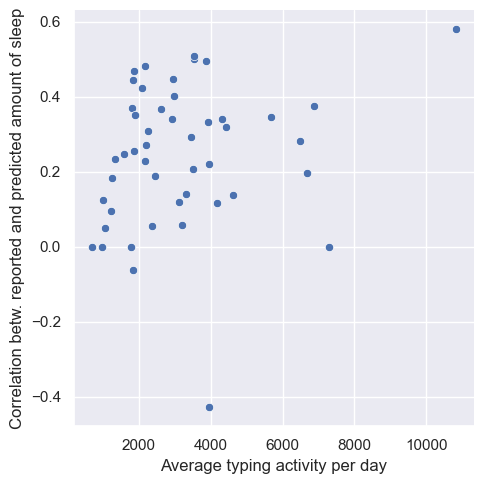

In [45]:
mats = [np.array(res['Mactivity']) for res in gsvd_results.values()]
cor_reports['activity_per_day'] = [np.sum(mat) / mat.shape[0] for mat in mats]

sns.relplot(cor_reports, x='activity_per_day', y='correlation')\
    .set(
        xlabel="Average typing activity per day",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity_per_day.png", dpi=300)